# Stroke Prediction

![](headers/stroke.jpg)

---

### Project Overview 
Stroke is the third leading cause of death in the United States, with over 140,000 people dying annually. Each year approximately 795,000 people suffer from a stroke with nearly 75% of these occuring in people over the age of 65. High blood pressure is the most important risk factor for stroke [(Stroke Center)](http://www.strokecenter.org/patients/about-stroke/stroke-statistics/#:~:text=More%20than%20140%2C000%20people%20die,and%20185%2C000%20are%20recurrent%20attacks.). The goal for this project will be to explore the data and find any correlations between features and the response variable stroke that will allow us to engineer new features for the data. Using these features, we then want to fit a classification model that will be able to predict whether or not a person has had a stroke or not, and in the future to predict the probability of a person having a stroke.

---

#### Data Information
The data originated from the [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) repository for stroke prediction. The following 11 features were recorded for 5110 observations: 

- `id`: unique identifier
- `gender`: "Male", "Female" or "Other"
- `age`: age of the patient
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- `ever_married`: "No" or "Yes"
- `work_type`: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- `Residence_type`: "Rural" or "Urban"
- `avg_glucose_level`: average glucose level in blood
- `bmi`: body mass index
- `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"
- `stroke`: 1 if the patient had a stroke, 0 if not

### Import Libraries / Data

In [2]:
# Import General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import itertools
import time

# Set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13
c_map = cm.get_cmap('tab10')

# Import SKLearn Modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Import Statistcs Modules
import statsmodels.api as sm
from imblearn import over_sampling, under_sampling
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Data Exploration / Feature Engineering

In [4]:
data.drop('id', axis=1, inplace=True)

In [5]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
len(data)

5110

### BMI (Body Mass Index)
The first feature we will want to explore is the BMI, which is also the only feature with missing data. We will want to asses the missing values and fill them with a determined value, as well as remove any outliers.

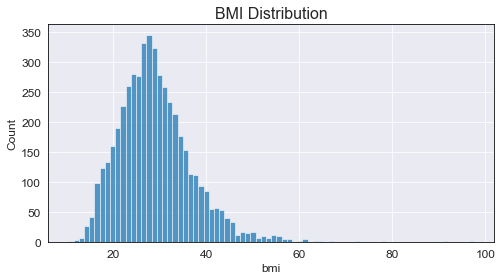

In [8]:
plt.figure(figsize=(8,4))
sns.histplot(x="bmi", data=data)
plt.title('BMI Distribution')
plt.show();

In [9]:
# Fill missing with values with median +/- random noises between [1,4]
error_term = np.round(np.sqrt(np.random.randint(1, 16, size=data.bmi.isna().sum())),2)
bmi_fill = data.bmi.median() + error_term

In [10]:
data.loc[data.bmi.isnull(), 'bmi'] = bmi_fill

In [11]:
# Remove any values above the 99th quantile (approx BMI = 53)
data = data[data.bmi < np.quantile(data.bmi, 0.99)]

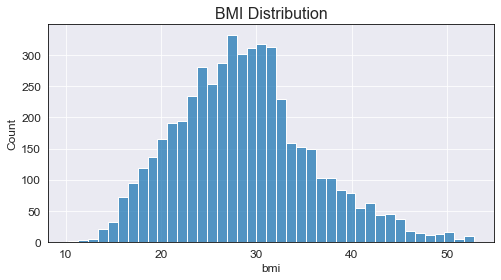

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(x="bmi", data=data)
plt.title('BMI Distribution')
plt.show();

We can see now that the distribution of BMI is much more normally distributed with the majority of observations focused around 29.

#### Weight Class (Feature Engineering)
We will now create a new feature using the bmi data, based on the [National Heart, Lung, and Blood Institute BMI Scale](https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmicalc.htm). Creating these will allow us the asses the weight for each person in the dataset. The link above gives us the following BMI categories:
- Underweight = Less than 18.5
- Normal weight = 18.5 - 24.9
- Overweight = 25 - 29.9
- Obesity = Greater than 30

In [13]:
def weight(row):
    if row['bmi'] >= 30:
        val = 'obese'
    elif ((row['bmi'] >= 25) & (row['bmi'] < 30)):
        val = 'over weight'
    elif ((row['bmi'] >= 18.5) & (row['bmi'] < 25)):
        val = 'normal weight'
    else:
        val = 'under weight'
    return val

data['weight_class'] = data.apply(weight, axis=1)

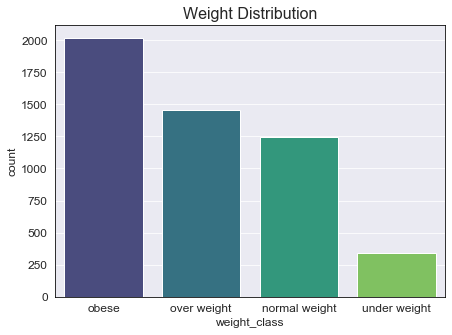

In [14]:
plt.figure(figsize=(7,5))
sns.countplot(x='weight_class', data=data, palette=sns.color_palette("viridis",4))
plt.title('Weight Distribution')
plt.show();

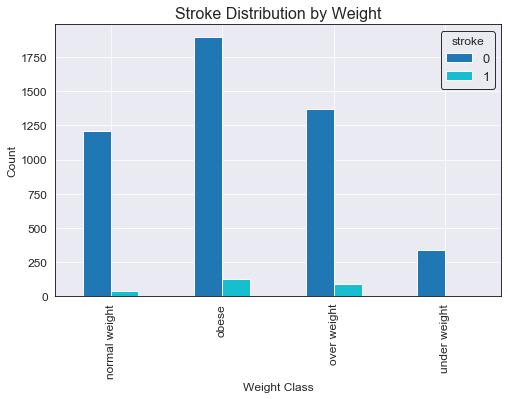

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='weight_class', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Weight Class')
plt.title('Stroke Distribution by Weight');

In [16]:
data[(data.weight_class == 'under weight') & (data.stroke == 1)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,weight_class
230,Female,81.0,0,0,Yes,Self-employed,Rural,81.95,16.9,never smoked,1,under weight


In [17]:
# Weight class age distribution
data.groupby('weight_class').agg(['min', 'mean', 'max'])['age']

,min,mean,max
weight_class,,,
normal weight,0.24,33.756267,82.0
obese,0.48,50.120099,82.0
over weight,1.32,49.174229,82.0
under weight,0.08,10.908843,82.0


It seems that the majority of the people observed in this dataset were either over weight or obese. Similarly, looking at the occurance of strokes for each class it seems that these two weight classes have the majority of the strokes as well. People who are underweight seemed to have close to 0 strokes, but looking further into the data for this weight class we can see that the majority of people in this weight class are around the age 11 (children), with the only person having stroke being 81.

### Age & Other Numerical Features
We now will explore the remaining numerical features in our dataset. We will want to see the distribution for age and average glucose levels, as well as seeing the correlation between hypertension and heart disease on having a stroke. In general, we will use the following variables:
- 0 - denotes not having a disease
- 1 - denotes having the disease

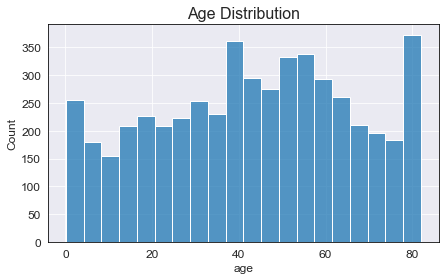

In [18]:
plt.figure(figsize=(7,4))
sns.histplot(x="age", data=data)
plt.title('Age Distribution')
plt.show();

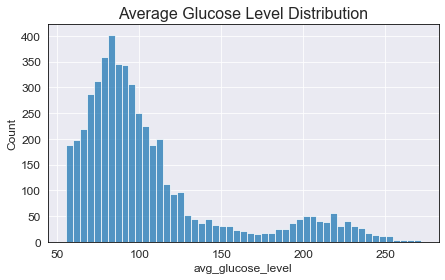

In [19]:
plt.figure(figsize=(7,4))
sns.histplot(x="avg_glucose_level", data=data)
plt.title('Average Glucose Level Distribution')
plt.show();

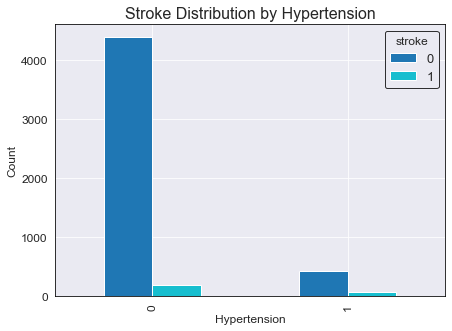

In [20]:
fig, ax = plt.subplots(figsize=(7, 5))
data.pivot_table(index='hypertension', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Hypertension')
plt.title('Stroke Distribution by Hypertension');

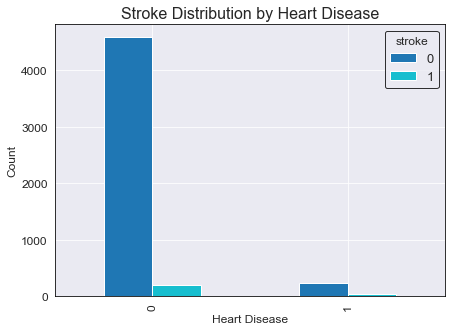

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
data.pivot_table(index='heart_disease', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Heart Disease')
plt.title('Stroke Distribution by Heart Disease');

Age does not seem to have a certain type of distribution (closest to a uniform distribution). Average Glucose seems to have a right skew, with a slight increase in the 180-220 range. For both hypertension and heart disease, people who do not have the disease were more likely to have a stroke. Similarly, we can see that both have the majority of their data being 0 (no disease), so we can't be sure too if no disease means less chance of stroke (maybe just less observations?).

#### Age Group (Feature Engineering)
Using the [Age Categories](https://www.statcan.gc.ca/eng/concepts/definitions/age2) from the Canadian Statistics website, we will create features for the life cycle groupings defined on their website:
- Children (0-14)
- Youth (15-24)
- Adults (25-64)
- Seniors (65+)

In [22]:
data['child'] = np.where(data.age < 15, 1, 0)
data['youth'] = np.where(((data.age >= 15) & (data.age < 25)), 1, 0)
data['adult'] = np.where(((data.age >= 25) & (data.age < 65)), 1, 0)
data['senior'] = np.where(data.age > 65, 1, 0)

In [23]:
def age(row):
    if row['child'] == 1:
        val = 'child'
    elif row['youth'] == 1:
        val = 'youth'
    elif row['adult'] == 1:
        val = 'adult'
    else:
        val = 'senior'
    return val

data['age_class'] = data.apply(age, axis=1)

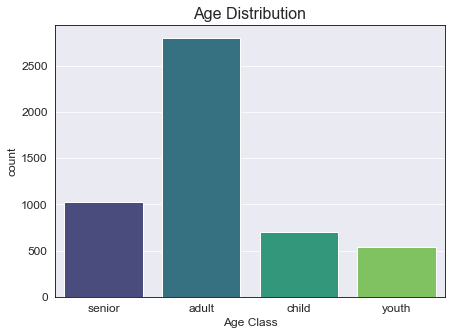

In [24]:
plt.figure(figsize=(7,5))
sns.countplot(x='age_class', data=data, palette=sns.color_palette("viridis",4))
plt.title('Age Distribution')
plt.xlabel('Age Class')
plt.show();

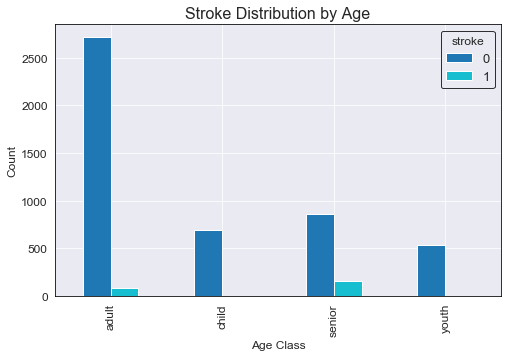

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='age_class', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Age Class')
plt.title('Stroke Distribution by Age');

In [26]:
data[((data.age_class == 'child') | (data.age_class == 'youth')) 
     & (data.stroke == 1)][['gender', 'age', 'bmi', 'weight_class','stroke']]

,gender,age,bmi,weight_class,stroke
162,Female,1.32,29.83,over weight,1
245,Female,14.00,30.90,obese,1


It seems that the majority of the people observed in the data were young adults (25-64). However, people categorized as seniors had the highest amount of strokes. It also looks like both children and youth have very low stroke rates, and looking into this further we can see only two female children (age 1 and 14) had strokes. An important note is that the two children who had strokes were both cateogirzed as obese with a BMI of approximately 30 for both. 

### Smoking Status, Gender, and Marriage
The remaining features we want to explore do not require any feature engineering with them as they are all categorical variables. We will want to explore the correlation between them and having a stroke in order to determine if we want to keep or drop them for the final model.

In [27]:
def stroke_ratio(feature):
    '''
    Create a pivot table for the number of strokes relative to the observations
    for a given feature. Ratio is returned as a percentage of the total subgroup
    that had a stroke.
    '''
    data_pivot = data.pivot_table(index=feature, columns='stroke', aggfunc='size')
    data_pivot['Ratio'] = round(data_pivot[1]/data_pivot[0], 4)*100
    return data_pivot.iloc[:,-1:]

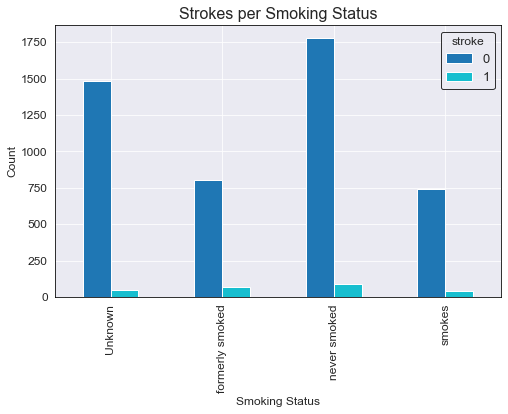

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='smoking_status', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Smoking Status')
plt.title('Strokes per Smoking Status');

In [29]:
stroke_ratio('smoking_status')

stroke,Ratio
smoking_status,
Unknown,3.16
formerly smoked,8.68
never smoked,5.00
smokes,5.68


There does not seem to be a clear distinction in which smoking status is linked to the highest likelihood of having a stroke, but people who have never smoked have had more strokes than people who do smoke (although looking at the ratio's found above, we can see people who smoke or previously smoked have had the most strokes in repsect to the subgroups).

In [30]:
data = data[data.gender != 'Other'] # remove gender = "Other" (only 1 obseration, done to simplify feature)

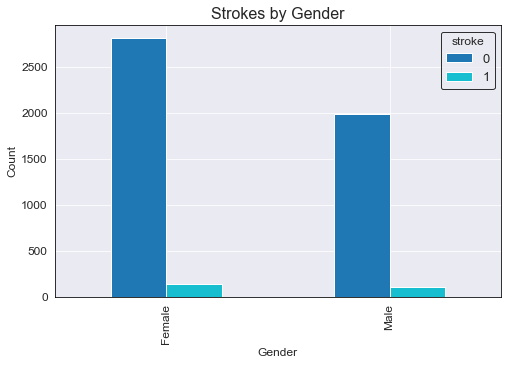

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='gender', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Strokes by Gender');

In [32]:
stroke_ratio('gender')

stroke,Ratio
gender,
Female,4.97
Male,5.42


We seem to have around 800 more females than males in our dataset, but the amount of strokes for each gender seem to be about equivalent. Similarly, their ratio in repsect to their group total are about equivalent.

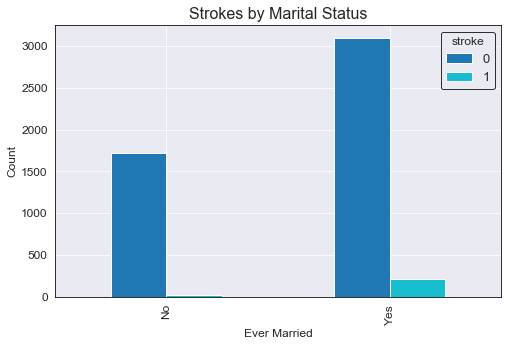

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='ever_married', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Ever Married')
plt.title('Strokes by Marital Status');

In [34]:
stroke_ratio('ever_married')

stroke,Ratio
ever_married,
No,1.69
Yes,7.08


We have about two times as many observations of people who have been married compared to those who have not. Similarly, looking at the ratios we can see than being married seems to have around 4x more strokes than never being married.

#### Remaining Categorical Features

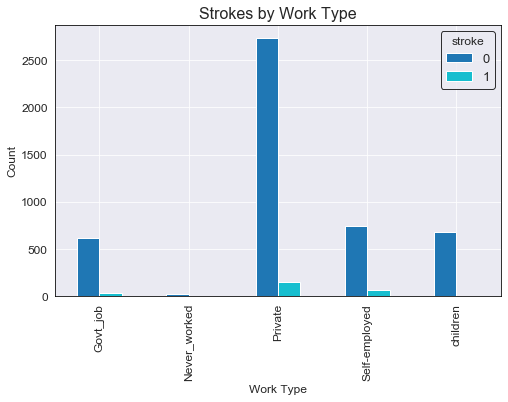

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='work_type', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Work Type')
plt.title('Strokes by Work Type');

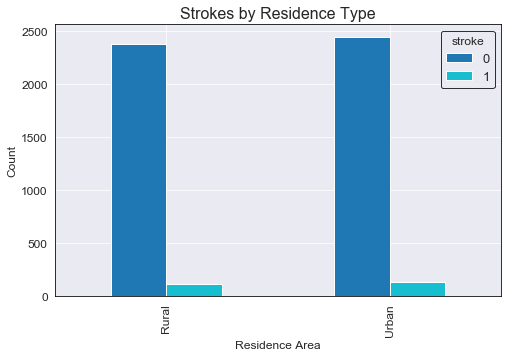

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='Residence_type', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Residence Area')
plt.title('Strokes by Residence Type');

Looking at the final two features, there does not seem to be a correlation between work or residence type with stroke. Private work seems to have the higest stroke count, but it also takes up the majority of observations. Residence type seem to be almost even between both types, so there is not much that would be useful in our model here.

# Data Preprocessing
Now that we have explored the data and created new features, we can begin to format the data so that it is in the format our model will need. We will want to:
- Drop all features that won't be used
- One-Hot-Encode categorical features (gender, ever_married, smoking_status)
- Plot correlation matrix for features kept for model (assess any features that should be dropped)

In [37]:
len(data) # original data had length 5110

5057

In [38]:
# Drop features that wont be used
data.drop(['work_type', 'Residence_type', 'age_class', 'gender'], axis=1, inplace=True)

In [39]:
data.head() # see current form of data (17 features)

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,weight_class,child,youth,adult,senior
0,67.0,0,1,Yes,228.69,36.6,formerly smoked,1,obese,0,0,0,1
1,61.0,0,0,Yes,202.21,29.1,never smoked,1,over weight,0,0,1,0
2,80.0,0,1,Yes,105.92,32.5,never smoked,1,obese,0,0,0,1
3,49.0,0,0,Yes,171.23,34.4,smokes,1,obese,0,0,1,0
4,79.0,1,0,Yes,174.12,24.0,never smoked,1,normal weight,0,0,0,1


Although previously we had made new features for *weight_class* and seperate features for each age group, to reduce the number of features in our model we will make two changes:
- Create an **age_over_45** feature, which according to the [NCBI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3006180/#:~:text=The%20risk%20increases%20with%20age,above%20the%20age%20of%2065.), the risk of stroke doubles for every decade after 45 years old.
- Create an **over_weight** feature which includes both over weight and obese people since according to the [NHLBI](https://www.nhlbi.nih.gov/health-topics/stroke), increases the risk of stroke.

In [40]:
data['ever_married'] = data['ever_married'].replace(['No', 'Yes'], [0,1])
data['age_over_45'] = np.where((data.age >= 45), 1, 0)
data['over_weight'] = np.where((data.bmi >= 25), 1, 0)
data['has_smoked'] = np.where(((data.smoking_status == 'formerly smoked') | (data.smoking_status == 'smokes')), 1, 0)
data['never_smoked'] = np.where(((data.smoking_status == 'never smoked') | (data.smoking_status == 'Unkown')), 1, 0)
data.drop(['smoking_status', 'child', 'youth', 'adult', 'senior', 'weight_class'], axis=1, inplace=True)

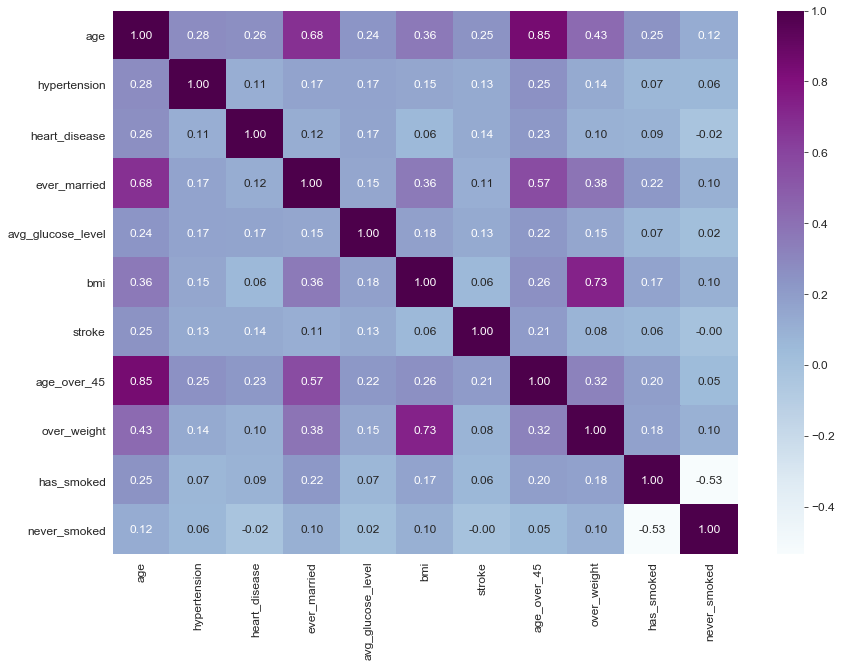

In [41]:
corr_matrix = data.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='BuPu')
plt.show();

Looking at the above matrix it seems that stroke has the highest correlation with the following features: age (0.25), age_over_45 (0.21), heart_disease (0.14), hyptertension (0.13), and avg_glucose_level (0.13). There are other features that are correlated with stroke that we engineered, but are lower than the ones listed previously. Now that our data is scaled and a subset of the features are kept, we can begin the modeling section. We also will want to save our data to use later so we do not have to keep re-running the notebook.

In [42]:
data.to_csv('stroke_data_processed.csv', index=False)

# Modeling

In [3]:
data = pd.read_csv('stroke_data_processed.csv')
data.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,age_over_45,over_weight,has_smoked,never_smoked
0,67.0,0,1,1,228.69,36.6,1,1,1,1,0
1,61.0,0,0,1,202.21,29.1,1,1,1,0,1
2,80.0,0,1,1,105.92,32.5,1,1,1,0,1
3,49.0,0,0,1,171.23,34.4,1,1,1,1,0
4,79.0,1,0,1,174.12,24.0,1,1,0,0,1


In [7]:
X = data.drop('stroke', axis=1)
y = data['stroke'].values

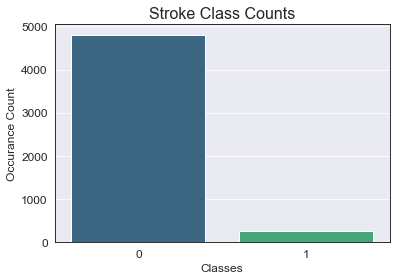

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(y, palette=sns.color_palette("viridis",2))
plt.xlabel('Classes')
plt.ylabel('Occurance Count')
plt.title('Stroke Class Counts')
plt.show();

## Base Model
We will begin by seeing what the base accuracy for our model would be if we were to assign 0 to all observations. We can see a clear class imbalance in the above graph (around 15x more **0** observations than **1**). Knowing this, we will need to take into account more than just the accuracy score for evaluating our model.

In [46]:
zeros_preds = np.zeros(len(data))
print(classification_report(y, zeros_preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4809
           1       0.00      0.00      0.00       248

    accuracy                           0.95      5057
   macro avg       0.48      0.50      0.49      5057
weighted avg       0.90      0.95      0.93      5057



In [47]:
ones_preds = np.ones(len(data))
print(classification_report(y, ones_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4809
           1       0.05      1.00      0.09       248

    accuracy                           0.05      5057
   macro avg       0.02      0.50      0.05      5057
weighted avg       0.00      0.05      0.00      5057



In [9]:
def plot_confusion_matrix(true_labels, y_preds, title, map_color):
    '''
    Plot an annotated confusion matrix to visualize the evaluation for
    our model predictions. Includes error labels and counts.
    '''
    cf_matrix = confusion_matrix(true_labels, y_preds)
    counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    labels = ['True Neg','False Pos','False Neg','True Pos']
    labels = [f'{label}\n{count}' for label,count in zip(labels, counts)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(5,4))
    sns.heatmap(cf_matrix, fmt='', annot=labels, cmap=map_color, linewidths=1, linecolor='black')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show();
    return None

*Note: Idea for this function came from this [Medium Article](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea) by Dennis T. on visualizing confusion matricies.*

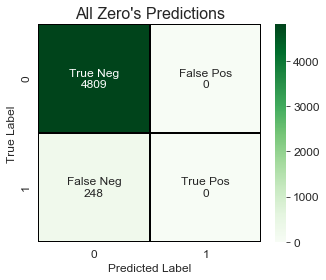

In [49]:
plot_confusion_matrix(y, zeros_preds, 'All Zero\'s Predictions', 'Greens')

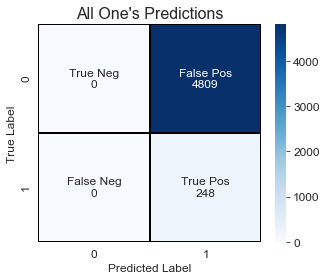

In [50]:
plot_confusion_matrix(y, ones_preds, 'All One\'s Predictions', 'Blues')

#### Evaluation Metric Setup
From assigning a predicted value of 0 for all observations, we can see our base model accuracy is around 95%. This indicates we will need a higher accuracy score in order for our model to be performing well. However, the main focus that we can see that we want to focus on avoiding *False Negatives* in our model, where we estimate no stroke when the patient had a stroke. We can interpret the following from the findings above:
- Using **Recall** as an evaluation metric will be extremely useful to avoid false negatives (all one's above had recall = 1, all zero's had recall = 0).
- We will also want to take into consideration *False Positives* (**precision**) so that we are not classifying strokes for people who have not had one. 
- Using a $F_{\beta}$ score focused more on recall (larger $\beta$ value) could also be useful.
- Accuracy will not be a key factor in the evaulation of our model (high accuracy can be acheived with base model).

## Statistical Modeling

Using [StatsModels](https://www.statsmodels.org/v0.10.1/), we will fit a Logistic Model on the processed stroke dataset. Knowing that we have a class imbalance from above, we will want to use **SMOTE** (Synthetic Minority Oversampling Technique) in order to sample from the Stroke class and balance our observations (currently, there is around 20x more "No Stroke" compared to "Stroke") for the training set.

For the testing set, we used the **NearMiss** algoirthm from [ImBalanced-Learn](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html) which performs under-sampling of the majority class with a 3:4 ratio of "Stroke":"No stroke" observations. I chose to do this because when fitting models using an oversampled test set, we had similar recall and higher precision, but I felt the results were not correctly reflecting the model since the minority class had so many repeated observations. For training this was fine, but for testing I only wanted one of each observation for the "Stroke" class.

*Note that we first split the data into training and testing sets before sampling in order to avoid having sampled observations for the minority class to appear in both the train and test sets, leading to the model overfitting since it would have already seen the exact observation it is predicting on.*

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

over_sampler = over_sampling.SMOTE(sampling_strategy=0.75, random_state=42)
under_sampler = under_sampling.NearMiss(sampling_strategy=0.75, version=2) # version 2 had highest precision score
X_train, y_train = over_sampler.fit_resample(X_train, y_train)
X_test, y_test = under_sampler.fit_resample(X_test, y_test)

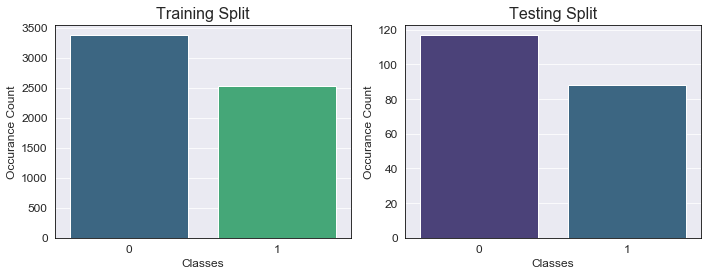

In [179]:
plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
sns.countplot(y_train, palette=sns.color_palette("viridis",2))
plt.xlabel('Classes')
plt.ylabel('Occurance Count')
plt.title('Training Split')
ax2 = plt.subplot(1,2,2)
sns.countplot(y_test, palette=sns.color_palette("viridis",5))
plt.xlabel('Classes')
plt.ylabel('Occurance Count')
plt.title('Testing Split')
plt.tight_layout()
plt.show();

In [180]:
# Create data frame for GLM model (X_train & y_train in same data frame)
data_glm = X_train.copy()
data_glm['stroke'] = y_train

In [213]:
# Fit with all variables
response_var = 'stroke ~ '
explanatory_vars = ' + '.join(X_train.columns.values)
formula = response_var + explanatory_vars

In [182]:
model = sm.GLM.from_formula(formula, family=sm.families.Binomial(), data=data_glm)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 5913
Model:                            GLM   Df Residuals:                     5902
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2358.9
Date:                Fri, 12 Mar 2021   Deviance:                       4717.8
Time:                        13:37:58   Pearson chi2:                 5.61e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -5.0058      0.249    -20.119      0.000      -5.493      -4.518
age                   0.0765      0.004     21.800      0.000       0.070       0.083
hypertension         -0.6779      0.116     -5.867      0.000      -0.904      -0.451
heart_disease        -0.9291      0.152     -6.127      0.000      -1.226      -0.632
ever_married         -1.1964      0.113    -10.622      0.000      -1.417      -0.976
avg_glucose_level     0.0050      0.001      6.952      0.000       0.004       0.006
bmi                   0.0344      0.008      4.287      0.000       0.019       0.050
age_over_45           1.0736      0.175      6.132      0.000       0.730       1.417
over_weight          -0.1373      0.115     -1.193      0.233      -0.363       0.088
has_smoked           -1.5021      0.090    -16.765      0.000      -1.678      -1.327
never_smoked         -1.8964      0.094    -20.178      0.000      -2.081      -1.712
=====================================================================================
"""

All features seem to be statistically significant, expect for over_weight (using a p-value < 0.05)

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       117
           1       0.53      0.45      0.49        88

    accuracy                           0.59       205
   macro avg       0.58      0.57      0.57       205
weighted avg       0.58      0.59      0.59       205



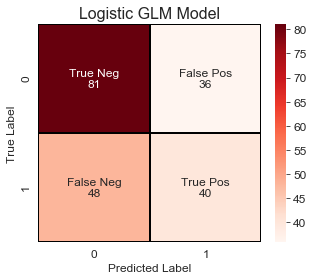

In [183]:
y_preds = round(result.predict(X_test))
print(classification_report(y_test, y_preds))
plot_confusion_matrix(y_test, y_preds, 'Logistic GLM Model', 'Reds')

The performance of the model using all features in the dataset is not good, our model is performing similar to if we were to randomly guess which class the observations belong to. We will want to raise the recall score (and decrease the False Negatives). Further, we will see if the False Positives can be decreased as well. We will do this by selecting subsets of features that are statistically significant in the following section.

### Feature Subset Selection

Now that we have fit a model using all features in our dataset, we can see that not every coefficient is statistically signficant (using a p-value of 0.05). In order to find the best combination of features, we will want to perform subset selection for the model. We will want to evaluate the perform of the models based on their BIC and Recall score, as well as taking into consideration an $F_{\beta}$ score with $\beta$ = 0.85. A $\beta$ value of 0.85 resulted in the best recall and precision score, any value higher resulted in a very low number of correctly classified "No Stroke" observations. We will perform subset selection in three different ways:
- **Forward Selection**
- **Exhaustive Selection**
- **Backward Selection**

*Citation: Idea came from the [Lab 8](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html) notebook from Smith College on subset selection in Python with StatsModels. The lab code was adapated to use different evaluations and modeling for this notebook.*

In [200]:
def fitModel(feature_subset):
    response_var = 'stroke ~ '
    explanatory_vars = ' + '.join(X_train[list(feature_subset)].columns.values)
    formula = response_var + explanatory_vars
    model = sm.GLM.from_formula(formula, family=sm.families.Binomial(), data=data_glm)
    result = model.fit()
    y_preds = round(result.predict(X_test[list(feature_subset)]))
    model_recall = recall_score(y_test, y_preds)
    model_fbeta = fbeta_score(y_test, y_preds, beta=0.85)
    return {'model': result, 'bic': result.bic, 'recall': model_recall, 
            'fbeta': model_fbeta, 'features' :X_train[list(feature_subset)].columns.values}

def forwardSelection(predictors):
    start = time.time()
    remaining_predictors = [p for p in X.columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(fitModel(predictors+[p]))
    
    models = pd.DataFrame(results)
    best_model = models.sort_values(by='fbeta', ascending=False).iloc[0,:]
    print("Processed", models.shape[0], "models on", len(predictors)+1, "predictors in", round(time.time()-start,3), "seconds.")
    
    return best_model.values

def exhaustiveSearch(k):
    start = time.time()
    results = []
    for combo in itertools.combinations(X_train, k):
        results.append(fitModel(combo))
    
    models = pd.DataFrame(results)
    best_model = models.sort_values(by='fbeta', ascending=False).iloc[0,:]
    print("Processed", models.shape[0], "models on", k, "predictors in", round(time.time()-start,3), "seconds.")
    
    return best_model.values

def backward(predictors):
    start = time.time()
    results = []
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(fitModel(combo))
    
    models = pd.DataFrame(results)
    best_model = models.sort_values(by='fbeta', ascending=False).iloc[0,:]
    print('Processed ', models.shape[0], 'models on', len(predictors)-1, "predictors in", round(time.time()-start,3), 'seconds.')
    
    return best_model.values

In [146]:
# Plot results from forward selection above
def plot_search_results(results):
    plt.figure(figsize=(16,4))
    xticks = np.arange(1,len(results)+1)
    colors = ['blue', 'red', 'green']
    for idx in range(1,4):
        ax = plt.subplot(1,3,idx)
        sns.scatterplot(x=xticks, y=results.iloc[:, idx], color=colors[idx-1])
        plt.xlabel('Number of Features')
        plt.title(f'{results.columns[idx]}')
        plt.ylabel(' ')
        plt.xticks(xticks)
    plt.show();
    return None

#### Forward Stepwise Feature Selection
The first method we will use is the forward stepwise selection, which will iterate over all of the features in the training dataset with each iteration adding the coefficient that improves our model the best. Each iteration will return the model with the highest $F_{0.5}$ score which we will then plot, evaluate, and use the best model to make predictions. 

In [214]:
models_fwd = pd.DataFrame(columns=["Model", "BIC", "Recall", "FBeta (0.85)", "Features"])
predictors = []

for i in range(1,len(data_glm.columns)):
    models_fwd.loc[i] = forwardSelection(predictors)
    predictors = models_fwd.loc[i]["Model"].model.exog_names[1:]

Processed 10 models on 1 predictors in 0.174 seconds.
Processed 9 models on 2 predictors in 0.201 seconds.
Processed 8 models on 3 predictors in 0.212 seconds.
Processed 7 models on 4 predictors in 0.201 seconds.
Processed 6 models on 5 predictors in 0.175 seconds.
Processed 5 models on 6 predictors in 0.166 seconds.
Processed 4 models on 7 predictors in 0.144 seconds.
Processed 3 models on 8 predictors in 0.117 seconds.
Processed 2 models on 9 predictors in 0.083 seconds.
Processed 1 models on 10 predictors in 0.046 seconds.


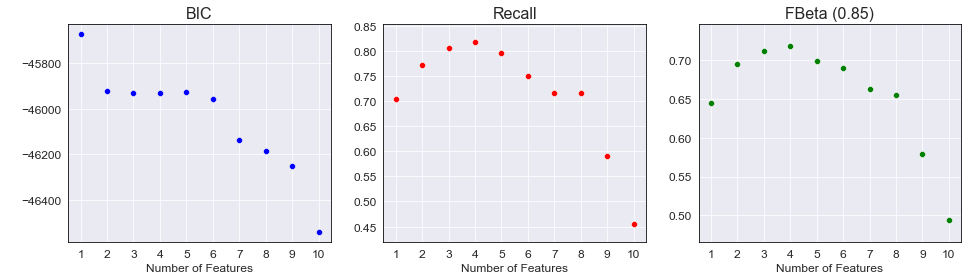

In [215]:
plot_search_results(models_fwd)

*Results here...*

In [203]:
models_fwd.loc[4]['Model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 5913
Model:                            GLM   Df Residuals:                     5908
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2690.3
Date:                Fri, 12 Mar 2021   Deviance:                       5380.5
Time:                        13:39:36   Pearson chi2:                 6.13e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.2738      0.248    -21.246      0.000      -5.760      -4.787
age              0.0751      0.003     22.870      0.000       0.069       0.082
never_smoked    -1.1923      0.077    -15.536      0.000      -1.343      -1.042
bmi              0.0196      0.006      3.318      0.001       0.008       0.031
age_over_45      0.4678      0.151      3.102      0.002       0.172       0.763
================================================================================
"""

              precision    recall  f1-score   support

           0       0.83      0.68      0.75       117
           1       0.66      0.82      0.73        88

    accuracy                           0.74       205
   macro avg       0.75      0.75      0.74       205
weighted avg       0.76      0.74      0.74       205



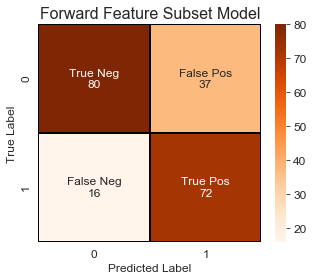

In [204]:
# Predict with model above
result = models_fwd.loc[4]['Model']
y_preds = round(result.predict(X_test[models_fwd.loc[4]['Features']]))
print(classification_report(y_test, y_preds))
plot_confusion_matrix(y_test, y_preds, 'Forward Feature Subset Model', 'Oranges')

After performing forward selection, we can see the ideal model uses 4 of the 10 original features. Although this model did not have the lowest BIC score, it did have the highest Recall and $F_{\beta}$ score of around 0.82 and 0.72 (respectively). All estimated coefficients are statistically significant (< 0.05). It seems the True Negatives decreased by 1, and the False Negatives decreased by 32. Our recall score increased by around 40% and the precision increased by 13% as well. The accuracy also increased by 15%.

#### Exhaustive Stepwise Feature Selection
The second method we will use is the exhaustive stepwise selection, which will try every combinations of predictors given a certain length (in this case, 1 through 10) and return the best model. Each iteration will return the model with the highest $F_{0.5}$ score which we will then plot, evaluate, and use the best model to make predictions. 

In [216]:
models_exhaust = pd.DataFrame(columns=["Model", "BIC", "Recall", "FBeta (0.85)", "Features"])

for i in range(1,11):
    models_exhaust.loc[i] = exhaustiveSearch(i)

Processed 10 models on 1 predictors in 0.189 seconds.
Processed 45 models on 2 predictors in 0.923 seconds.
Processed 120 models on 3 predictors in 2.888 seconds.
Processed 210 models on 4 predictors in 5.522 seconds.
Processed 252 models on 5 predictors in 7.362 seconds.
Processed 210 models on 6 predictors in 6.551 seconds.
Processed 120 models on 7 predictors in 4.046 seconds.
Processed 45 models on 8 predictors in 1.635 seconds.
Processed 10 models on 9 predictors in 0.405 seconds.
Processed 1 models on 10 predictors in 0.044 seconds.


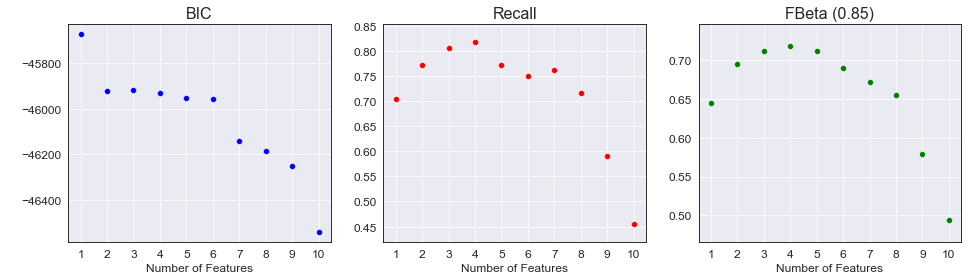

In [217]:
# Plot results from exhaustive selection above
plot_search_results(models_exhaust)

In [207]:
models_exhaust.loc[4]['Model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 5913
Model:                            GLM   Df Residuals:                     5908
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2690.3
Date:                Fri, 12 Mar 2021   Deviance:                       5380.5
Time:                        13:41:00   Pearson chi2:                 6.13e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.2738      0.248    -21.246      0.000      -5.760      -4.787
age              0.0751      0.003     22.870      0.000       0.069       0.082
bmi              0.0196      0.006      3.318      0.001       0.008       0.031
age_over_45      0.4678      0.151      3.102      0.002       0.172       0.763
never_smoked    -1.1923      0.077    -15.536      0.000      -1.343      -1.042
================================================================================
"""

              precision    recall  f1-score   support

           0       0.83      0.68      0.75       117
           1       0.66      0.82      0.73        88

    accuracy                           0.74       205
   macro avg       0.75      0.75      0.74       205
weighted avg       0.76      0.74      0.74       205



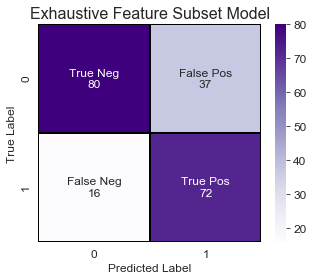

In [208]:
# Predict with model above
result = models_exhaust.loc[4]['Model']
y_preds = round(result.predict(X_test[models_exhaust.loc[4]['Features']]))
print(classification_report(y_test, y_preds))
plot_confusion_matrix(y_test, y_preds, 'Exhaustive Feature Subset Model', 'Purples')

Similar to the forward selection, the exhaustive selection results reported that the same 4 features resulted in the best model.

#### Backwards Stepwise Feature Selection
The last method we will use is the backwards stepwise selection, which will begin with all of our features in the dataset, and each iteration it will drop the least significant coefficient. Each iteration will return the model with the highest $F_{0.5}$ score which we will then plot, evaluate, and use the best model to make predictions. 

In [218]:
models_bwd = pd.DataFrame(columns=["Model", "BIC", "Recall", "FBeta (0.85)", "Features"])

predictors = X_train.columns
while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["Model"].model.exog_names[1:]

Processed  10 models on 9 predictors in 0.394 seconds.
Processed  9 models on 8 predictors in 0.382 seconds.
Processed  8 models on 7 predictors in 0.288 seconds.
Processed  7 models on 6 predictors in 0.218 seconds.
Processed  6 models on 5 predictors in 0.182 seconds.
Processed  5 models on 4 predictors in 0.129 seconds.
Processed  4 models on 3 predictors in 0.106 seconds.
Processed  3 models on 2 predictors in 0.065 seconds.
Processed  2 models on 1 predictors in 0.038 seconds.


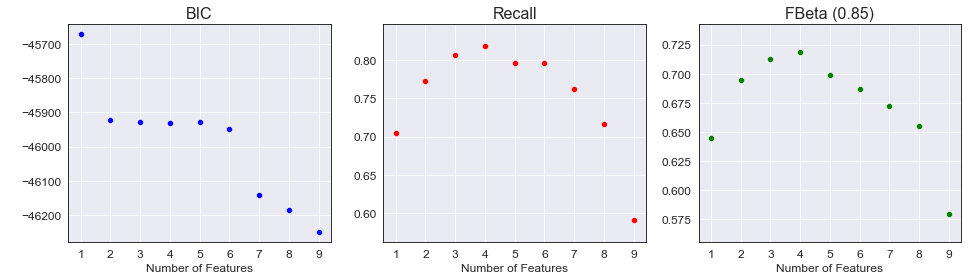

In [219]:
# Plot results from backward selection above
models_bwd_flipped = models_bwd.iloc[::-1] # flip since backwards goes 10, 9, 8,...
plot_search_results(models_bwd_flipped)

In [211]:
models_bwd_flipped.loc[4]['Model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 5913
Model:                            GLM   Df Residuals:                     5908
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2690.3
Date:                Fri, 12 Mar 2021   Deviance:                       5380.5
Time:                        13:41:17   Pearson chi2:                 6.13e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.2738      0.248    -21.246      0.000      -5.760      -4.787
age              0.0751      0.003     22.870      0.000       0.069       0.082
bmi              0.0196      0.006      3.318      0.001       0.008       0.031
age_over_45      0.4678      0.151      3.102      0.002       0.172       0.763
never_smoked    -1.1923      0.077    -15.536      0.000      -1.343      -1.042
================================================================================
"""

              precision    recall  f1-score   support

           0       0.83      0.68      0.75       117
           1       0.66      0.82      0.73        88

    accuracy                           0.74       205
   macro avg       0.75      0.75      0.74       205
weighted avg       0.76      0.74      0.74       205



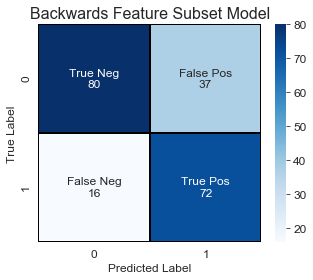

In [212]:
# Predict with model above
result = models_bwd.loc[4]['Model']
y_preds = round(result.predict(X_test[models_bwd.loc[4]['Features']]))
print(classification_report(y_test, y_preds))
plot_confusion_matrix(y_test, y_preds, 'Backwards Feature Subset Model', 'Blues')

Similar to the forward selection, the backwards selection results reported that the same 4 features resulted in the best model.

**Conclusion**:  

In conclusion, all 3 subset selection methods resulted in the same model with matching coefficients and p-values. This ensures that we have found the best combination of features for our model in order to maximize the $F_{0.85}$ score. Over the original model which used all features, we have the following changes with the 4 feature model:
- True Negatives decreased by 1 and False Positives increased by 1.
- False Negatives decreased by 32 and True Positive increased by 32.
- The precision score increased from 53% to 66%.
- The recall score increased from 45% to 82%.
- The accuracy score increased from 59% to 74%.

**IMPORTANT**: The models were not evaluated on recall since doing this resulted in models with recall in the high 90%'s, but no correctly classified 0 labels. Although we need a high recall, we also need to ensure our precision stayed at a reasonable number (we don't want to be classifying people that won't have strokes as being likely to have one).

## Ensemble Modeling